# CAD model

## Load the model

In [1]:
######################################################################
# Packages needed
######################################################################

# # Install hddm and related packages
# !pip install scikit-learn
# !pip install cython
# !pip install pymc==2.3.8
# !pip install git+https://github.com/AlexanderFengler/ssms@main
# !pip install -U --no-deps git+https://github.com/hddm-devs/hddm
# !pip install -U --no-deps git+https://github.com/hddm-devs/kabuki

# Import packages
import numpy as np                        # general stuff
from scipy import optimize                # minimization of the cost function
import pandas as pd                       # data manipulation
# import hddm                               # for the ddm sample
# from hddm import utils                    # for hddm
# import pymc as pm                         # for hddm
# import pymc.progressbar as pbar           # for hddm
# from kabuki.hierarchical import Knode     # for hddm
import matplotlib.pyplot as plt           # plotting
import seaborn as sns                     # plotting
from matplotlib import cm                 # plotting
# 

######################################################################
# Optimal control functions
######################################################################

def calculate_value(params,w1,w2,t):
    """
    ---------------------------------------------------------------------------------
    Calculate the value of a particular control setting         
    --------
    Inputs:
    --------
    v: drift rate (params)
    a: threshold (params)
    w1: weight for the correct responses
    w2: weight for the errors
    t: non-decision tme
    --------
    Outputs:
    --------
    rr: value of the given control settings
    ---------------------------------------------------------------------------------
    """  
    v,a = params

    er = 1 / (1 + np.exp(2 * a * v))

    dt = np.abs(a / v * np.tanh(a * v))

    # Calculate the reward rate
    rr = (w1 * (1 - er) - w2 * er) / (dt + t) - intensity_cost(v,a) 
    rr = -rr

    return rr

def intensity_cost(v,a):
    """
    ---------------------------------------------------------------------------------
    Calculate the intensity cost         
    --------
    Inputs:
    --------
    v: drift rate
    a: threshold
    --------
    Outputs:
    --------
    intensity_cost: a scalar
    ---------------------------------------------------------------------------------
    """  
    intensity_cost = v**2
    return intensity_cost

def optimal_control(w1,w2,t,initial_guess,bounds):
    """
    ---------------------------------------------------------------------------------
    Find the optimal control signals which maximizes the expected value         
    --------
    Inputs:
    --------
    w1: weight for the correct responses
    w2: weight for the errors
    t: non-decision tme
    initial_guess: starting point for the optimizer
    bounds: bounds on the v&a values

    --------
    Outputs:
    --------
    v_star: optimal drift rate
    a_star: optimal threshold
    ---------------------------------------------------------------------------------
    """  
    result = optimize.minimize(calculate_value, initial_guess,args=(w1,w2,t),bounds=bounds) 
    v_star = result.x[0]
    a_star = result.x[1]
    return v_star, a_star


######################################################################
# Control movement function
######################################################################
def ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta):
    """
    ---------------------------------------------------------------------------------
    Calculates the control trajectory through the drift-rate - threshold space.            
    --------
    Inputs:
    --------
    a0:      threshold starting point (from the previous trial or prior)
    v0:      drift-rate starting point (from the previous trial or prior)
    inputs:  vector of drift rates and thresholds for different goals (v_star and a_star given by the optimal control algorithm) across all timepoints
    goals:   vector of optimal points (v_star and a_star) for each condition
    tau:    decay parameter given by the optimal control algorithm
    eta:    noise parameter
    dt:     time step (default is 0.005 s)
    g:      gain of the sigmoid function
    theta:  bias term for the sigmoid function
    --------
    Outputs:
    --------
    a_traject, v_traject
    ---------------------------------------------------------------------------------
    """
    
    # Initialize the trajectory arrays
    v_traject = np.zeros(len(inputs['v']))
    a_traject = np.zeros(len(inputs['a']))

    # Normalize the inputs to 0-1 range
    v_star = rangenormalize(inputs['v'],goals['v'][0],goals['v'][1])
    a_star = rangenormalize(inputs['a'],goals['a'][0],goals['a'][1])

    # Normalize the initial values to 0-1 range
    v=rangenormalize(v0,goals['v'][0],goals['v'][1]) # Initial value
    a=rangenormalize(a0,goals['a'][0],goals['a'][1]) # Initial value

    for i in range(0, len(inputs['v'])):

        # Calculate the change
        dv = -tau * v * dt + tau * S(g,theta,v_star[i])*dt + np.random.normal(0, eta**2 * dt)
        av = -tau * a * dt + tau * S(g,theta,a_star[i])*dt + np.random.normal(0, eta**2 * dt)
        # Update
        v = v + dv
        a = a + av

        # Save
        v_traject[i] = v
        a_traject[i] = a

    # Denormalize the values
    v_traject = rangedenormalize(v_traject,goals['v'][0],goals['v'][1])
    a_traject = rangedenormalize(a_traject,goals['a'][0],goals['a'][1])
    
    return a_traject, v_traject

######################################################################
# Normalization functions
######################################################################

def rangenormalize(value,min_value,max_value):
  """normalize a value to 0-1 range
  """
  # Deal with the case when min and max are the same (fixed blocks)
  if min_value==max_value:
    min_value = min_value-0.1
  
  normalized_value = (value - min_value) / (max_value - min_value)
  return normalized_value

def rangedenormalize(value,min_value,max_value):
  """normalize a value to 0-1 range
  """
  # Deal with the case when min and max are the same (fixed blocks)
  if min_value==max_value:
    min_value = min_value-0.1
    
  denormalized_value = (value * (max_value - min_value)) + min_value
  return denormalized_value

def S(g,theta,x): 
    """
    ---------------------------------------------------------------------------------
    Logistic saturation function, with slope modulated by a gain parameter            
    --------
    Inputs:
    --------
    g:      gain of the sigmoid function
    theta:  bias of the sigmoid function
    x:      input
    --------
    Outputs:
    --------
    y:      output
    ---------------------------------------------------------------------------------
    """
    return 1/(1 + np.exp(-g*(x-theta)))



######################################################################
# Input generation function (for simulations)
######################################################################

def input(goals, soa, switch, nintervals):
    """
    ---------------------------------------------------------------------------------
    Create inputs (goal states over time) for the simulations       
    --------
    Inputs:
    --------
    goals: a list of different goal states (drift rates and thresholds across conditions) and the corresponding conditions
    soa: the number of timepoints during which control is adjusted
    switch: the number of goal switches
    nintervals: the number of intervals (the number of times with fixed goal state)
    
    --------
    Outputs:
    --------
    inputs: a list with a vector of inputs for drift and threshold
    ---------------------------------------------------------------------------------
    """     
   
    #Check that the trial number is divisible by 2 soa * switch
    if not (((nintervals) % (switch*len(goals['v']))) == 0):
        raise ValueError("Interval number is not divisible by goals * switch")
    
    if len(goals['v']) == 2:
        v = np.tile(np.concatenate((np.repeat(goals['v'][0],switch*soa),np.repeat(goals['v'][1],switch*soa))), int((nintervals)/(switch*len(goals['conditions']))))
        a = np.tile(np.concatenate((np.repeat(goals['a'][0],switch*soa),np.repeat(goals['a'][1],switch*soa))), int((nintervals)/(switch*len(goals['conditions']))))
        conditions = np.tile(np.concatenate((np.repeat(goals['conditions'][0],switch*soa),np.repeat(goals['conditions'][1],switch*soa))), int((nintervals)/(switch*len(goals['conditions']))))
    elif len(goals['v']) == 3:
        goals_array_v = np.array([goals['v'][0], goals['v'][1], goals['v'][2]])
        goals_array_a = np.array([goals['a'][0], goals['a'][1], goals['a'][2]])
        conditions_array = np.array([goals['conditions'][0], goals['conditions'][1], goals['conditions'][2]])
        combined_array = np.column_stack((goals_array_v, goals_array_a, conditions_array))
        n_tiles = int(nintervals / (switch * len(goals['conditions'])))
        v = np.empty((0,))
        a = np.empty((0,))
        conditions = np.empty((0,))
        for _ in range(n_tiles):
            np.random.shuffle(combined_array)
            #np.random.shuffle(goals_array_a)
            concatenated_array_v = np.concatenate([np.repeat(goal, switch*soa) for goal in combined_array[:,0]])
            concatenated_array_a = np.concatenate([np.repeat(goal, switch*soa) for goal in combined_array[:,1]])
            concatenated_array_conditions = np.concatenate([np.repeat(goal, switch*soa) for goal in combined_array[:,2]])
            v = np.concatenate((v, concatenated_array_v))
            a = np.concatenate((a, concatenated_array_a))
            conditions = np.concatenate((conditions, concatenated_array_conditions))
            conditions = conditions.astype(int)
        v = v[:nintervals*soa*switch]
        a = a[:nintervals*soa*switch]

        #conditions = np.tile(np.concatenate((np.repeat(goals['conditions'][0],switch*soa),np.repeat(goals['conditions'][1],switch*soa),np.repeat(goals['conditions'][2],switch*soa))), int((nintervals)/(switch*len(goals['conditions']))))

    inputs = {'v':v,
              'a':a,
              'conditions':conditions}
    
    return inputs

######################################################################
# DDM function
######################################################################

# Take one sample
#data = hddm.generate.gen_rand_data(params= {'v': v, 'a': a, 't': 0},size=1, subjs=1)



## Parameters shared by all the models

In [2]:
v0 = 3
a0 = 0.8
initial_guess = [v0,a0]
bounds = ((0.1,10), (0.1,10))
tau = 0.2
dt = 0.005
eta = 0.1
g = 5
theta = 0.5

## Study 1

### Simulate

In [3]:
# Parameters 
t = 0.3171
soa = 1500
switch = 2

#------------------------------------------------------------------------------
# VARYING BLOCK
#------------------------------------------------------------------------------
nintervals = 200
w1_0 = 8.6160  # Correct resp sensitivity for condition 0
w1_1 = 12.1718  # Correct resp sensitivity for condition 1
w2_0 = 30.3912 # Incorrect resp sensitivity for condition 0
w2_1 = 916.7092 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([0,1])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the summary results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_varying = results
results_varying["block_type"] = np.repeat('varying',results_varying.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject


results_varying_dynamics = results_dynamics
results_varying_dynamics["block_type"] = np.repeat('varying',results_varying_dynamics.shape[0]) ## Add the block information

#------------------------------------------------------------------------------
# FIXED BLOCK (CONDITION 0)
#------------------------------------------------------------------------------
nintervals = 100
w1_0 = 8.6160  # Correct resp sensitivity for condition 0
w1_1 = 8.6160  # Correct resp sensitivity for condition 1
w2_0 = 30.3912 # Incorrect resp sensitivity for condition 0
w2_1 = 30.3912 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([0,0])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_fixed_cond0 = results
results_fixed_cond0["block_type"] = np.repeat('fixed',results_fixed_cond0.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_fixed_cond0_dynamics = results_dynamics
results_fixed_cond0_dynamics["block_type"] = np.repeat('fixed',results_fixed_cond0_dynamics.shape[0]) ## Add the block information

#------------------------------------------------------------------------------
# FIXED BLOCK (CONDITION 1)
#------------------------------------------------------------------------------
nintervals = 100
w1_0 = 12.1718  # Correct resp sensitivity for condition 0
w1_1 = 12.1718  # Correct resp sensitivity for condition 1
w2_0 = 916.7092 # Incorrect resp sensitivity for condition 0
w2_1 = 916.7092 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([1,1])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_fixed_cond1 = results
results_fixed_cond1["block_type"] = np.repeat('fixed',results_fixed_cond1.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_fixed_cond1_dynamics = results_dynamics
results_fixed_cond1_dynamics["block_type"] = np.repeat('fixed',results_fixed_cond1_dynamics.shape[0]) ## Add the block information

# Merge the results
results = pd.concat([results_varying,results_fixed_cond0,results_fixed_cond1], axis=0)
results_dynamics = pd.concat([results_varying_dynamics,results_fixed_cond0_dynamics,results_fixed_cond1_dynamics], axis=0)


### 2D plot

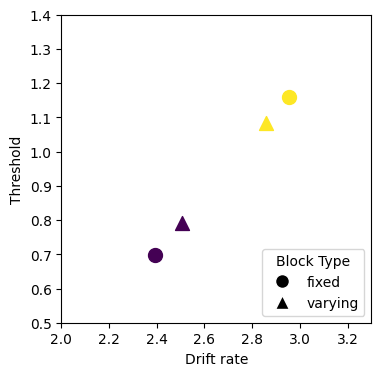

In [4]:
# Calculate the means
means = results.groupby(['condition', 'block_type']).mean()

# Define colors for conditions
cmap = cm.get_cmap('viridis', len(means.index.get_level_values('condition').unique()))

# Set marker shapes for block types
marker_shapes = {'fixed': 'o', 'varying': '^'}

# Create the plot
fig, ax = plt.subplots(figsize=(4, 4))

for (condition, block_type), data in means.iterrows():
    v = data['v']
    a = data['a']
    color = cmap(condition)
    marker = marker_shapes[block_type]
    ax.scatter(v, a, color=color, marker=marker, s=100, label=block_type)

ax.set_xlabel('Drift rate')
ax.set_ylabel('Threshold')
ax.set_xlim([2,3.3])  # Set the x-axis limits
ax.set_ylim([0.5,1.4])  # Set the y-axis limits

# Custom legend handler function
def create_legend_handler(color, marker):
    line = plt.Line2D([], [], marker=marker, color='w', markerfacecolor='k', markersize=10)
    return line

# Create legend handles and labels
legend_handles = [create_legend_handler(cmap(i), marker) for i, marker in enumerate(marker_shapes.values())]
legend_labels = list(means.index.get_level_values('block_type').unique())

# Display legend in the lower right corner
ax.legend(legend_handles, legend_labels, title='Block Type', loc='lower right')

plt.show()

# Save means into a csv file on a specified path
means.to_csv('../../Analyses/Experiment1/model_simulations/Experiment1.csv')


### Dynamics plot

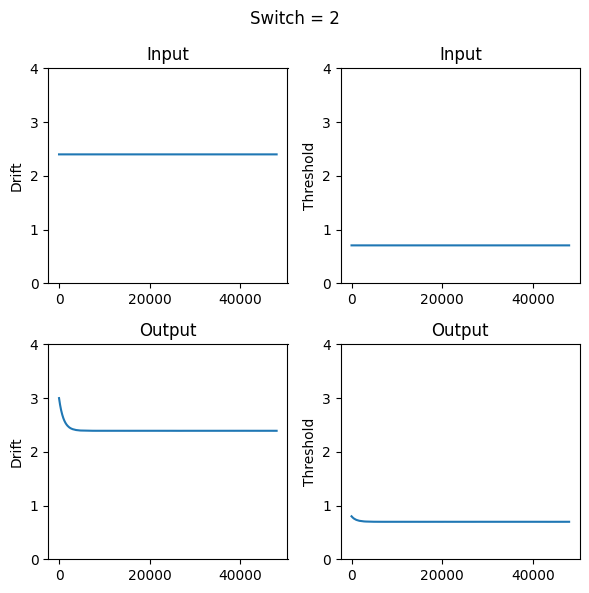

In [6]:
# Subset the data
dynamics = results_dynamics[results_dynamics['block_type'] == 'fixed']

# Take only the first 16 SOAs
dynamics = dynamics.iloc[0:32*soa,:]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
fig.suptitle('Switch = {}'.format(switch))

# Drift rate
axs[0,0].plot(dynamics['v_star'])
axs[0,0].set_title('Input')
axs[0,0].set_ylim(0,4)
axs[0,0].set_ylabel('Drift')

axs[1,0].plot(dynamics['v_traject'])
axs[1,0].set_title('Output')
axs[1,0].set_ylim(0,4)
axs[1,0].set_ylabel('Drift')

# Threshold
axs[0,1].plot(dynamics['a_star'])
axs[0,1].set_title('Input')
axs[0,1].set_ylim(0,4)
axs[0,1].set_ylabel('Threshold')

axs[1,1].plot(dynamics['a_traject'])
axs[1,1].set_title('Output')
axs[1,1].set_ylim(0,4)
axs[1,1].set_ylabel('Threshold')

plt.tight_layout()
plt.show()

### Switch vs. repeat in varying blocks

#### 2D plot

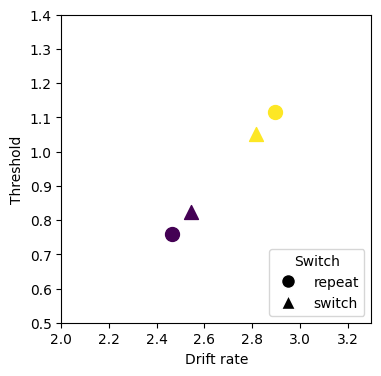

In [41]:
results_varying = results[results['block_type'] == 'varying'].copy()

# Initialize the 'switch' column with NaN values
results_varying['switch'] = pd.NA

# Iterate over each row and label as 'switch' or 'repeat' based on the condition
for i in range(1, len(results_varying)):
    if results_varying.loc[i, 'condition'] != results_varying.loc[i-1, 'condition']:
        results_varying.loc[i, 'switch'] = 'switch'
    else:
        results_varying.loc[i, 'switch'] = 'repeat'

results_varying = results_varying.dropna(subset=['switch'])

# Calculate the means 
means = results_varying.groupby(['condition', 'switch']).mean()

# Define colors for conditions
cmap = cm.get_cmap('viridis', len(means.index.get_level_values('condition').unique()))

# Set marker shapes for block types
marker_shapes = {'repeat': 'o', 'switch': '^'}

# Create the plot
fig, ax = plt.subplots(figsize=(4, 4))

for (condition, switch), data in means.iterrows():
    v = data['v']
    a = data['a']
    color = cmap(condition)
    marker = marker_shapes[switch]
    ax.scatter(v, a, color=color, marker=marker, s=100, label=switch)

ax.set_xlabel('Drift rate')
ax.set_ylabel('Threshold')
ax.set_xlim([2, 3.3])  # Set the x-axis limits
ax.set_ylim([0.5, 1.4])  # Set the y-axis limits

# Custom legend handler function
def create_legend_handler(color, marker):
    line = plt.Line2D([], [], marker=marker, color='w', markerfacecolor='k', markersize=10)
    return line

# Create legend handles and labels
legend_handles = [create_legend_handler(cmap(i), marker) for i, marker in enumerate(marker_shapes.values())]
legend_labels = list(means.index.get_level_values('switch').unique())

# Display legend in the lower right corner
ax.legend(legend_handles, legend_labels, title='Switch', loc='lower right')

plt.show()

# Save means into a csv file on a specified path
means.to_csv('../../Analyses/Experiment1/model_simulations/Experiment1_Switch.csv')


## Study 2 

### Simulate

In [82]:
# Parameters 
t = 0.3316689
soa = 1500
switch = 1

#------------------------------------------------------------------------------
# VARYING BLOCK
#------------------------------------------------------------------------------
nintervals = 900
w1_0 = 11.8997  # Correct resp sensitivity for condition 0
w1_1 = 17.8829  # Correct resp sensitivity for condition 1
w1_2 = 15.1896  # Correct resp sensitivity for condition 2
w2_0 = 32.9760 # Incorrect resp sensitivity for condition 0
w2_1 = 3673.4 # Incorrect resp sensitivity for condition 1
w2_2 = 435.9743 # Incorrect resp sensitivity for condition 2
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)
v_star2, a_star2 = optimal_control(w1_2,w2_2,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1,v_star2]),
         'a':np.array([a_star0,a_star1,a_star2]),
         'conditions':np.array([0,1,2])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_varying = results
results_varying["block_type"] = np.repeat('varying',results_varying.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_varying_dynamics = results_dynamics
results_varying_dynamics["block_type"] = np.repeat('varying',results_varying_dynamics.shape[0]) ## Add the block information

#------------------------------------------------------------------------------
# FIXED BLOCK (CONDITION 0)
#------------------------------------------------------------------------------
nintervals = 300
w1_0 = 11.8997  # Correct resp sensitivity for condition 0
w1_1 = 11.8997  # Correct resp sensitivity for condition 1
w2_0 = 32.9760 # Incorrect resp sensitivity for condition 0
w2_1 = 32.9760 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([0,0])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_fixed_cond0 = results
results_fixed_cond0["block_type"] = np.repeat('fixed',results_fixed_cond0.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_fixed_cond0_dynamics = results_dynamics
results_fixed_cond0_dynamics["block_type"] = np.repeat('fixed',results_fixed_cond0_dynamics.shape[0]) ## Add the block information

#------------------------------------------------------------------------------
# FIXED BLOCK (CONDITION 1)
#------------------------------------------------------------------------------
nintervals = 300
w1_0 = 17.8829  # Correct resp sensitivity for condition 0
w1_1 = 17.8829  # Correct resp sensitivity for condition 1
w2_0 = 3673.4 # Incorrect resp sensitivity for condition 0
w2_1 = 3673.4 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([1,1])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_fixed_cond1 = results
results_fixed_cond1["block_type"] = np.repeat('fixed',results_fixed_cond1.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_fixed_cond1_dynamics = results_dynamics
results_fixed_cond1_dynamics["block_type"] = np.repeat('fixed',results_fixed_cond1_dynamics.shape[0]) ## Add the block information


#------------------------------------------------------------------------------
# FIXED BLOCK (CONDITION 2)
#------------------------------------------------------------------------------
nintervals = 300
w1_0 = 15.1896  # Correct resp sensitivity for condition 0
w1_1 = 15.1896  # Correct resp sensitivity for condition 1
w2_0 = 435.9743 # Incorrect resp sensitivity for condition 0
w2_1 = 435.9743 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([2,2])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_fixed_cond2 = results
results_fixed_cond2["block_type"] = np.repeat('fixed',results_fixed_cond2.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_fixed_cond2_dynamics = results_dynamics
results_fixed_cond2_dynamics["block_type"] = np.repeat('fixed',results_fixed_cond2_dynamics.shape[0]) ## Add the block information

# Merge the results
results = pd.concat([results_varying,results_fixed_cond0,results_fixed_cond1,results_fixed_cond2], axis=0)
results_dynamics = pd.concat([results_varying_dynamics,results_fixed_cond0_dynamics,results_fixed_cond1_dynamics,results_fixed_cond2_dynamics], axis=0)


### 2D plot

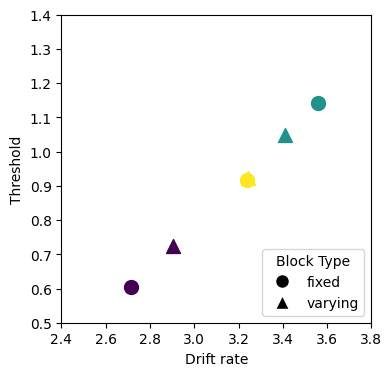

In [43]:
# Calculate the means 
means = results.groupby(['condition', 'block_type']).mean()

# Define colors for conditions
cmap = cm.get_cmap('viridis', len(means.index.get_level_values('condition').unique()))

# Set marker shapes for block types
marker_shapes = {'fixed': 'o', 'varying': '^'}

# Create the plot
fig, ax = plt.subplots(figsize=(4, 4))

for (condition, block_type), data in means.iterrows():
    v = data['v']
    a = data['a']
    color = cmap(condition)
    marker = marker_shapes[block_type]
    ax.scatter(v, a, color=color, marker=marker, s=100, label=block_type)

ax.set_xlabel('Drift rate')
ax.set_ylabel('Threshold')
ax.set_xlim([2.4,3.8])  # Set the x-axis limits
ax.set_ylim([0.5,1.4])  # Set the y-axis limits

# Custom legend handler function
def create_legend_handler(color, marker):
    line = plt.Line2D([], [], marker=marker, color='w', markerfacecolor='k', markersize=10)
    return line

# Create legend handles and labels
legend_handles = [create_legend_handler(cmap(i), marker) for i, marker in enumerate(marker_shapes.values())]
legend_labels = list(means.index.get_level_values('block_type').unique())

# Display legend in the lower right corner
ax.legend(legend_handles, legend_labels, title='Block Type', loc='lower right')

plt.show()

# Save means into a csv file on a specified path
means.to_csv('../../Analyses/Experiment2/model_simulations/Experiment2.csv')

### Dynamics plot

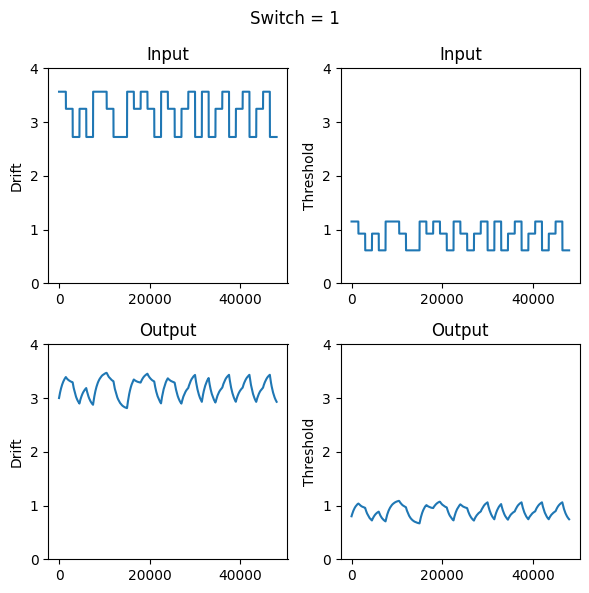

In [44]:
# Subset the data
dynamics = results_dynamics[results_dynamics['block_type'] == 'varying']

# Take only the first 16 SOAs
dynamics = dynamics.iloc[0:32*soa,:]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
fig.suptitle('Switch = {}'.format(switch))

# Drift rate
axs[0,0].plot(dynamics['v_star'])
axs[0,0].set_title('Input')
axs[0,0].set_ylim(0,4)
axs[0,0].set_ylabel('Drift')

axs[1,0].plot(dynamics['v_traject'])
axs[1,0].set_title('Output')
axs[1,0].set_ylim(0,4)
axs[1,0].set_ylabel('Drift')

# Threshold
axs[0,1].plot(dynamics['a_star'])
axs[0,1].set_title('Input')
axs[0,1].set_ylim(0,4)
axs[0,1].set_ylabel('Threshold')

axs[1,1].plot(dynamics['a_traject'])
axs[1,1].set_title('Output')
axs[1,1].set_ylim(0,4)
axs[1,1].set_ylabel('Threshold')

plt.tight_layout()
plt.show()

## Study 3 

### Simulate

In [45]:
# Parameters 
t = 0.3903721
switch = 1

#------------------------------------------------------------------------------
# VARYING BLOCK - SOA 250ms
#------------------------------------------------------------------------------
soa = 1000
nintervals = 200
w1_0 = 15.6543  # Correct resp sensitivity for condition 0
w1_1 = 16.5850  # Correct resp sensitivity for condition 1
w2_0 = 145.7659 # Incorrect resp sensitivity for condition 0
w2_1 = 671.9738 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([0,1])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_varying_250 = results
results_varying_250["block_type"] = np.repeat('varying',results_varying_250.shape[0]) ## Add the block information
results_varying_250["soa"] = np.repeat('250',results_varying_250.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['condition'] = inputs['conditions']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_varying_250_dynamics = results_dynamics
results_varying_250_dynamics["block_type"] = np.repeat('varying',results_varying_250_dynamics.shape[0]) ## Add the block information
results_varying_250_dynamics["soa"] = np.repeat('250',results_varying_250_dynamics.shape[0]) ## Add the block information

#------------------------------------------------------------------------------
# VARYING BLOCK - SOA 1000ms
#------------------------------------------------------------------------------
soa = 1750
nintervals = 200
w1_0 = 15.6543  # Correct resp sensitivity for condition 0
w1_1 = 16.5850  # Correct resp sensitivity for condition 1
w2_0 = 145.7659 # Incorrect resp sensitivity for condition 0
w2_1 = 671.9738 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([0,1])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_varying_1000 = results
results_varying_1000["block_type"] = np.repeat('varying',results_varying_1000.shape[0]) ## Add the block information
results_varying_1000["soa"] = np.repeat('1000',results_varying_1000.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['condition'] = inputs['conditions']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_varying_1000_dynamics = results_dynamics
results_varying_1000_dynamics["block_type"] = np.repeat('varying',results_varying_1000_dynamics.shape[0]) ## Add the block information
results_varying_1000_dynamics["soa"] = np.repeat('1000',results_varying_1000_dynamics.shape[0]) ## Add the block information

#------------------------------------------------------------------------------
# FIXED BLOCK (CONDITION 0): SOA 250ms
#------------------------------------------------------------------------------
soa = 1000
nintervals = 100
w1_0 = 15.6543 # Correct resp sensitivity for condition 0
w1_1 = 15.6543  # Correct resp sensitivity for condition 1
w2_0 = 145.7659 # Incorrect resp sensitivity for condition 0
w2_1 = 145.7659 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([0,0])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_fixed_cond0_250 = results
results_fixed_cond0_250["block_type"] = np.repeat('fixed',results_fixed_cond0_250.shape[0]) ## Add the block information
results_fixed_cond0_250["soa"] = np.repeat('250',results_fixed_cond0_250.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['condition'] = inputs['conditions']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_fixed_cond0_250_dynamics = results_dynamics
results_fixed_cond0_250_dynamics["block_type"] = np.repeat('varying',results_fixed_cond0_250_dynamics.shape[0]) ## Add the block information
results_fixed_cond0_250_dynamics["soa"] = np.repeat('250',results_fixed_cond0_250_dynamics.shape[0]) ## Add the block information

#------------------------------------------------------------------------------
# FIXED BLOCK (CONDITION 0): SOA 1000ms
#------------------------------------------------------------------------------
soa = 1750
nintervals = 100
w1_0 = 15.6543 # Correct resp sensitivity for condition 0
w1_1 = 15.6543  # Correct resp sensitivity for condition 1
w2_0 = 145.7659 # Incorrect resp sensitivity for condition 0
w2_1 = 145.7659 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([0,0])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_fixed_cond0_1000 = results
results_fixed_cond0_1000["block_type"] = np.repeat('fixed',results_fixed_cond0_1000.shape[0]) ## Add the block information
results_fixed_cond0_1000["soa"] = np.repeat('1000',results_fixed_cond0_1000.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['condition'] = inputs['conditions']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_fixed_cond0_1000_dynamics = results_dynamics
results_fixed_cond0_1000_dynamics["block_type"] = np.repeat('varying',results_fixed_cond0_1000_dynamics.shape[0]) ## Add the block information
results_fixed_cond0_1000_dynamics["soa"] = np.repeat('1000',results_fixed_cond0_1000_dynamics.shape[0]) ## Add the block information

#------------------------------------------------------------------------------
# FIXED BLOCK (CONDITION 1): SOA 250ms
#------------------------------------------------------------------------------
soa = 1000
nintervals = 100
w1_0 = 16.5850  # Correct resp sensitivity for condition 0
w1_1 = 16.5850  # Correct resp sensitivity for condition 1
w2_0 = 671.9738 # Incorrect resp sensitivity for condition 0
w2_1 = 671.9738 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([1,1])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_fixed_cond1_250 = results
results_fixed_cond1_250["block_type"] = np.repeat('fixed',results_fixed_cond1_250.shape[0]) ## Add the block information
results_fixed_cond1_250["soa"] = np.repeat('250',results_fixed_cond1_250.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['condition'] = inputs['conditions']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_fixed_cond1_250_dynamics = results_dynamics
results_fixed_cond1_250_dynamics["block_type"] = np.repeat('varying',results_fixed_cond1_250_dynamics.shape[0]) ## Add the block information
results_fixed_cond1_250_dynamics["soa"] = np.repeat('250',results_fixed_cond1_250_dynamics.shape[0]) ## Add the block information


#------------------------------------------------------------------------------
# FIXED BLOCK (CONDITION 1): SOA 1000ms
#------------------------------------------------------------------------------
soa = 1750
nintervals = 100
w1_0 = 16.5850  # Correct resp sensitivity for condition 0
w1_1 = 16.5850  # Correct resp sensitivity for condition 1
w2_0 = 671.9738 # Incorrect resp sensitivity for condition 0
w2_1 = 671.9738 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([1,1])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_fixed_cond1_1000 = results
results_fixed_cond1_1000["block_type"] = np.repeat('fixed',results_fixed_cond1_1000.shape[0]) ## Add the block information
results_fixed_cond1_1000["soa"] = np.repeat('1000',results_fixed_cond1_1000.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['condition'] = inputs['conditions']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_fixed_cond1_1000_dynamics = results_dynamics
results_fixed_cond1_1000_dynamics["block_type"] = np.repeat('varying',results_fixed_cond1_1000_dynamics.shape[0]) ## Add the block information
results_fixed_cond1_1000_dynamics["soa"] = np.repeat('1000',results_fixed_cond1_1000_dynamics.shape[0]) ## Add the block information

# Merge the results
results = pd.concat([results_varying_250,results_varying_1000,results_fixed_cond0_250,results_fixed_cond0_1000,results_fixed_cond1_250,results_fixed_cond1_1000], axis=0)
results_dynamics = pd.concat([results_varying_250_dynamics,results_varying_1000_dynamics,results_fixed_cond0_250_dynamics,results_fixed_cond0_1000_dynamics,results_fixed_cond1_250_dynamics,results_fixed_cond1_1000_dynamics], axis=0)


### 2D plot

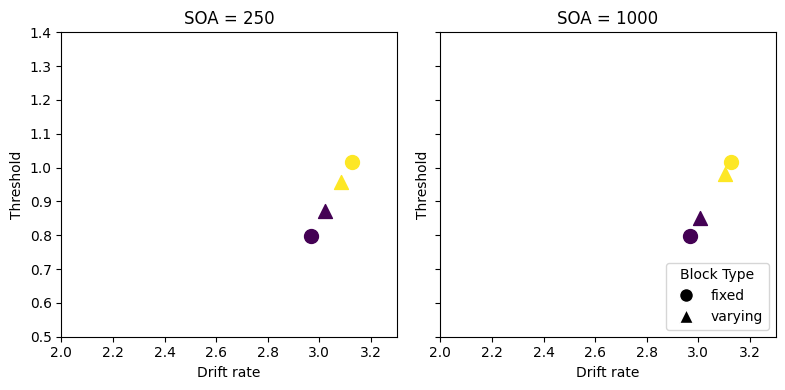

In [46]:
# Convert 'soa' column to integer type
results['soa'] = results['soa'].astype(int)

# Calculate the means 
means = results.groupby(['soa', 'condition', 'block_type']).mean()

# Define colors for conditions
cmap = cm.get_cmap('viridis', len(means.index.get_level_values('condition').unique()))

# Set marker shapes for block types
marker_shapes = {'fixed': 'o', 'varying': '^'}

# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

# Plot for soa = 250
for (condition, block_type), data in means.loc[250].iterrows():
    v = data['v']
    a = data['a']
    color = cmap(condition)
    marker = marker_shapes[block_type]
    ax1.scatter(v, a, color=color, marker=marker, s=100, label=block_type)

ax1.set_title('SOA = 250')
ax1.set_xlabel('Drift rate')
ax1.set_ylabel('Threshold')
ax1.set_xlim([2, 3.3])
ax1.set_ylim([0.5, 1.4])

# Plot for soa = 1000
for (condition, block_type), data in means.loc[1000].iterrows():
    v = data['v']
    a = data['a']
    color = cmap(condition)
    marker = marker_shapes[block_type]
    ax2.scatter(v, a, color=color, marker=marker, s=100, label=block_type)

ax2.set_title('SOA = 1000')
ax2.set_xlabel('Drift rate')
ax2.set_ylabel('Threshold')
ax1.set_xlim([2, 3.3])
ax1.set_ylim([0.5, 1.4])

# Custom legend handler function
def create_legend_handler(color, marker):
    line = plt.Line2D([], [], marker=marker, color='w', markerfacecolor='k', markersize=10)
    return line

# Create legend handles and labels
legend_handles = [create_legend_handler(cmap(i), marker) for i, marker in enumerate(marker_shapes.values())]
legend_labels = list(means.index.get_level_values('block_type').unique())

# Display legend in the lower right corner of the second subplot
ax2.legend(legend_handles, legend_labels, title='Block Type', loc='lower right')

plt.tight_layout()
plt.show()

# Save means into a csv file on a specified path
means.to_csv('../../Analyses/Experiment3/model_simulations/Experiment3.csv')



### Dynamics plot

#### SOA = 250ms

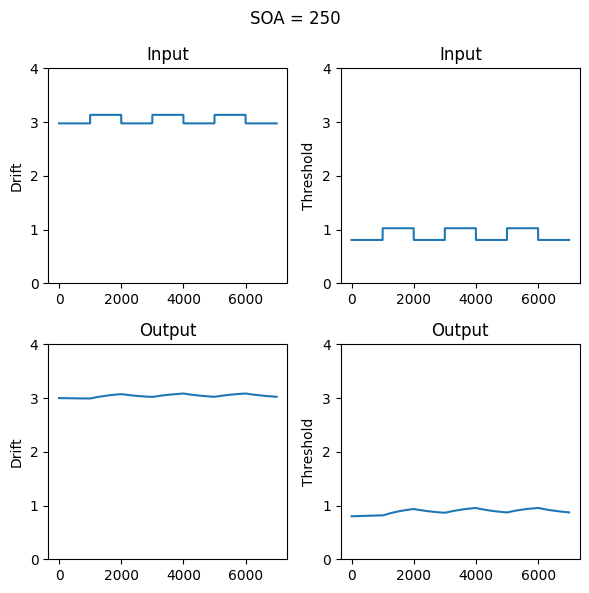

In [47]:
# Subset the data
dynamics = results_dynamics[results_dynamics['block_type'] == 'varying']
dynamics = results_dynamics[results_dynamics['soa'] == '250']

# Take only the first 16 SOAs
dynamics = dynamics.iloc[0:4*soa,:]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
fig.suptitle('SOA = 250')

# Define colors for conditions
color_map = {'1': 'red', '2': 'blue'}  # Update with actual condition names

# Drift rate
axs[0,0].plot(dynamics['v_star'])
axs[0,0].set_title('Input')
axs[0,0].set_ylim(0,4)
axs[0,0].set_ylabel('Drift')

axs[1,0].plot(dynamics['v_traject'])
axs[1,0].set_title('Output')
axs[1,0].set_ylim(0,4)
axs[1,0].set_ylabel('Drift')

# Threshold
axs[0,1].plot(dynamics['a_star'])
axs[0,1].set_title('Input')
axs[0,1].set_ylim(0,4)
axs[0,1].set_ylabel('Threshold')

axs[1,1].plot(dynamics['a_traject'])
axs[1,1].set_title('Output')
axs[1,1].set_ylim(0,4)
axs[1,1].set_ylabel('Threshold')

plt.tight_layout()
plt.show()

#### SOA = 1000ms

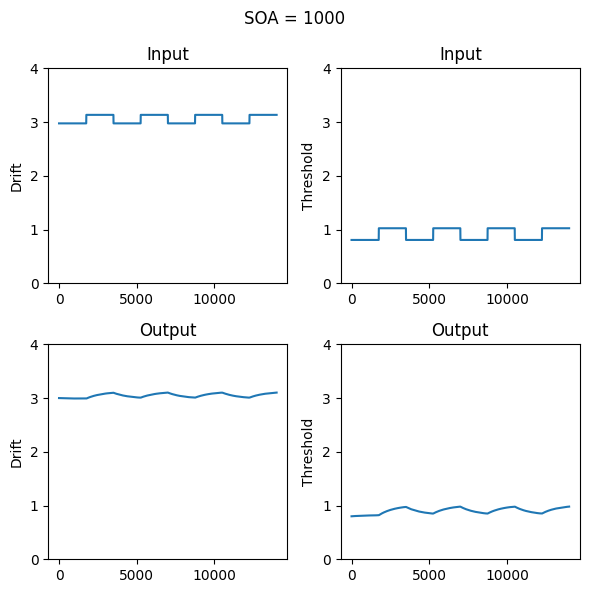

In [48]:
# Subset the data
dynamics = results_dynamics[results_dynamics['block_type'] == 'varying']
dynamics = results_dynamics[results_dynamics['soa'] == '1000']

# Take only the first 16 SOAs
dynamics = dynamics.iloc[0:8*soa,:]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
fig.suptitle('SOA = 1000')

# Define colors for conditions
color_map = {'1': 'red', '2': 'blue'}  # Update with actual condition names

# Drift rate
axs[0,0].plot(dynamics['v_star'])
axs[0,0].set_title('Input')
axs[0,0].set_ylim(0,4)
axs[0,0].set_ylabel('Drift')

axs[1,0].plot(dynamics['v_traject'])
axs[1,0].set_title('Output')
axs[1,0].set_ylim(0,4)
axs[1,0].set_ylabel('Drift')

# Threshold
axs[0,1].plot(dynamics['a_star'])
axs[0,1].set_title('Input')
axs[0,1].set_ylim(0,4)
axs[0,1].set_ylabel('Threshold')

axs[1,1].plot(dynamics['a_traject'])
axs[1,1].set_title('Output')
axs[1,1].set_ylim(0,4)
axs[1,1].set_ylabel('Threshold')

plt.tight_layout()
plt.show()

## Study 4 

### Fixed

#### Simulate

In [6]:
# Parameters 
t = 0.3831758
soa = 2750 
nintervals = 256
switch = 4

#------------------------------------------------------------------------------
# FIXED BLOCK (CONDITION 0)
#------------------------------------------------------------------------------
w1_0 = 17.7866  # Correct resp sensitivity for condition 0
w1_1 = 17.7866  # Correct resp sensitivity for condition 1
w2_0 = 136.0729 # Incorrect resp sensitivity for condition 0
w2_1 = 136.0729 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([0,0])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_fixed_cond0 = results
results_fixed_cond0["block_type"] = np.repeat('fixed',results_fixed_cond0.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['condition'] = inputs['conditions']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_fixed_cond0_dynamics = results_dynamics
results_fixed_cond0_dynamics["block_type"] = np.repeat('fixed',results_fixed_cond0_dynamics.shape[0]) ## Add the block information

#------------------------------------------------------------------------------
# FIXED BLOCK (CONDITION 1)
#------------------------------------------------------------------------------
w1_0 = 20.5033 # Correct resp sensitivity for condition 0
w1_1 = 20.5033  # Correct resp sensitivity for condition 1
w2_0 = 1787.4 # Incorrect resp sensitivity for condition 0
w2_1 = 1787.4 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([1,1])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_fixed_cond1 = results
results_fixed_cond1["block_type"] = np.repeat('fixed',results_fixed_cond1.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['condition'] = inputs['conditions']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_fixed_cond1_dynamics = results_dynamics
results_fixed_cond1_dynamics["block_type"] = np.repeat('fixed',results_fixed_cond1_dynamics.shape[0]) ## Add the block information

# Merge the results
results = pd.concat([results_fixed_cond0,results_fixed_cond1], axis=0)
results_dynamics = pd.concat([results_fixed_cond0_dynamics,results_fixed_cond1_dynamics], axis=0)


#### 2D plot

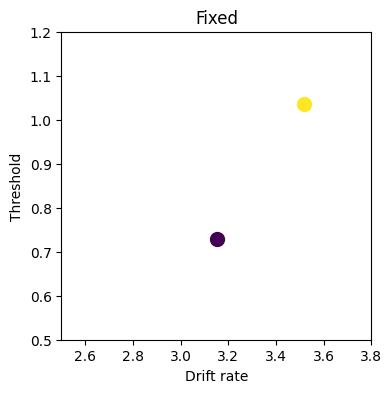

In [5]:
# Calculate the means 
means = results.groupby(['condition']).mean()

# Define colors for conditions
cmap = cm.get_cmap('viridis', len(means.index.get_level_values('condition').unique()))

# Create the plot
fig, ax = plt.subplots(figsize=(4, 4))

for (condition), data in means.iterrows():
    v = data['v']
    a = data['a']
    color = cmap(condition)
    ax.scatter(v, a, color=color, s=100)

ax.set_xlabel('Drift rate')
ax.set_ylabel('Threshold')
ax.set_xlim([2.5,3.8])  # Set the x-axis limits
ax.set_ylim([0.5,1.2])  # Set the y-axis limits
ax.set_title('Fixed')

plt.show()

# Save means into a csv file on a specified path
means.to_csv('../../Analyses/Experiment4/model_simulations/Experiment4_fixed_g_fixed_5.csv')

#### Dynamics plot

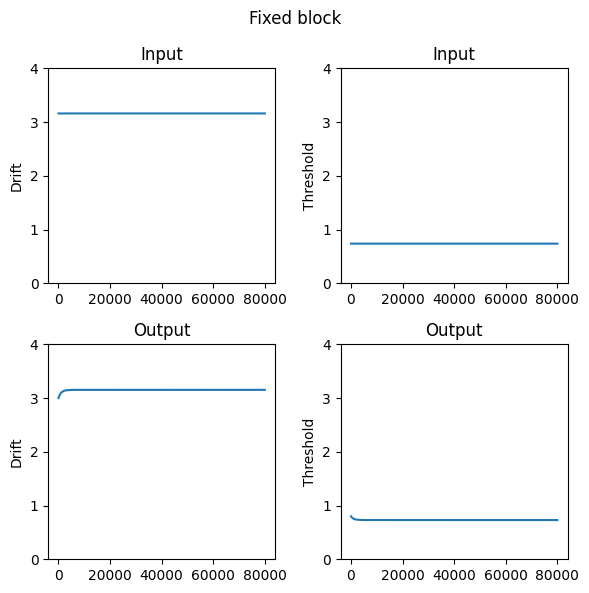

In [51]:
# Subset the data
dynamics = results_dynamics

# Take only the first 16 SOAs
dynamics = dynamics.iloc[0:32*soa,:]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
fig.suptitle('Fixed block')

# Define colors for conditions
color_map = {'1': 'red', '2': 'blue'}  # Update with actual condition names

# Drift rate
axs[0,0].plot(dynamics['v_star'])
axs[0,0].set_title('Input')
axs[0,0].set_ylim(0,4)
axs[0,0].set_ylabel('Drift')

axs[1, 0].plot(dynamics['v_traject'])
axs[1,0].set_title('Output')
axs[1,0].set_ylim(0,4)
axs[1,0].set_ylabel('Drift')

# Threshold
axs[0,1].plot(dynamics['a_star'])
axs[0,1].set_title('Input')
axs[0,1].set_ylim(0,4)
axs[0,1].set_ylabel('Threshold')

axs[1,1].plot(dynamics['a_traject'])
axs[1,1].set_title('Output')
axs[1,1].set_ylim(0,4)
axs[1,1].set_ylabel('Threshold')

plt.tight_layout()
plt.show()

### Switch every 8

#### Simulate

In [7]:
# Parameters 
t = 0.3831758
soa = 2750 
nintervals = 512

#------------------------------------------------------------------------------
# SWITCH 8 BLOCK
#------------------------------------------------------------------------------
switch = 8
w1_0 = 17.7866  # Correct resp sensitivity for condition 0
w1_1 = 20.5033  # Correct resp sensitivity for condition 1
w2_0 = 136.0729 # Incorrect resp sensitivity for condition 0
w2_1 = 1787.4 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([0,1])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_varying = results
results_varying["block_type"] = np.repeat('varying',results_varying.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['condition'] = inputs['conditions']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_varying_dynamics = results_dynamics
results_varying_dynamics["block_type"] = np.repeat('varying',results_varying_dynamics.shape[0]) ## Add the block information

# Merge the results
results = results_varying
results_dynamics = results_varying_dynamics




#### 2D plot

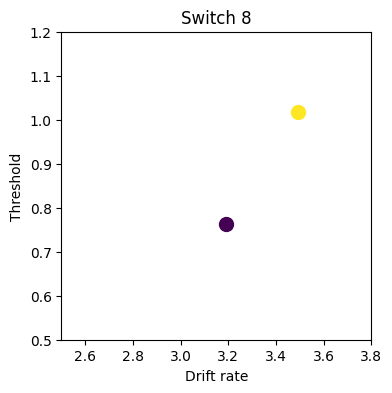

In [8]:
# Calculate the means 
means = results.groupby(['condition']).mean()

# Define colors for conditions
cmap = cm.get_cmap('viridis', len(means.index.get_level_values('condition').unique()))

# Create the plot
fig, ax = plt.subplots(figsize=(4, 4))

for (condition), data in means.iterrows():
    v = data['v']
    a = data['a']
    color = cmap(condition)
    ax.scatter(v, a, color=color, s=100)

ax.set_xlabel('Drift rate')
ax.set_ylabel('Threshold')
ax.set_xlim([2.5,3.8])  # Set the x-axis limits
ax.set_ylim([0.5,1.2])  # Set the y-axis limits
ax.set_title('Switch 8')

plt.show()

# Save means into a csv file on a specified path
means.to_csv('../../Analyses/Experiment4/model_simulations/Experiment4_8_g_fixed_5.csv')

#### Dynamics plot

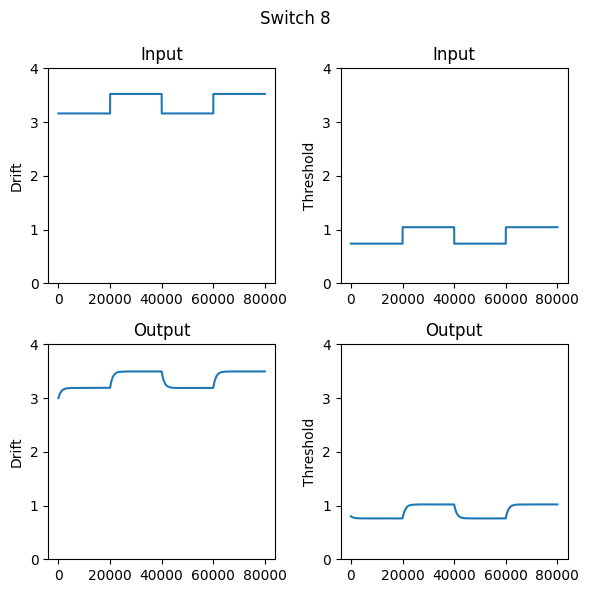

In [54]:
# Subset the data
dynamics = results_dynamics

# Take only the first 16 SOAs
dynamics = dynamics.iloc[0:32*soa,:]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
fig.suptitle('Switch 8')

# Define colors for conditions
color_map = {'1': 'red', '2': 'blue'}  # Update with actual condition names

# Drift rate
axs[0,0].plot(dynamics['v_star'])
axs[0,0].set_title('Input')
axs[0,0].set_ylim(0,4)
axs[0,0].set_ylabel('Drift')

axs[1, 0].plot(dynamics['v_traject'])
axs[1,0].set_title('Output')
axs[1,0].set_ylim(0,4)
axs[1,0].set_ylabel('Drift')

# Threshold
axs[0,1].plot(dynamics['a_star'])
axs[0,1].set_title('Input')
axs[0,1].set_ylim(0,4)
axs[0,1].set_ylabel('Threshold')

axs[1,1].plot(dynamics['a_traject'])
axs[1,1].set_title('Output')
axs[1,1].set_ylim(0,4)
axs[1,1].set_ylabel('Threshold')

plt.tight_layout()
plt.show()

### Switch every 4

#### Simulate

In [9]:
# Parameters 
t = 0.3831758
soa = 2750 
nintervals = 512

#------------------------------------------------------------------------------
# SWITCH 4 BLOCK
#------------------------------------------------------------------------------
switch = 4
w1_0 = 17.7866  # Correct resp sensitivity for condition 0
w1_1 = 20.5033  # Correct resp sensitivity for condition 1
w2_0 = 136.0729 # Incorrect resp sensitivity for condition 0
w2_1 = 1787.4 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([0,1])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_varying = results
results_varying["block_type"] = np.repeat('varying',results_varying.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['condition'] = inputs['conditions']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_varying_dynamics = results_dynamics
results_varying_dynamics["block_type"] = np.repeat('varying',results_varying_dynamics.shape[0]) ## Add the block information

# Merge the results
results = results_varying
results_dynamics = results_varying_dynamics


#### 2D plot

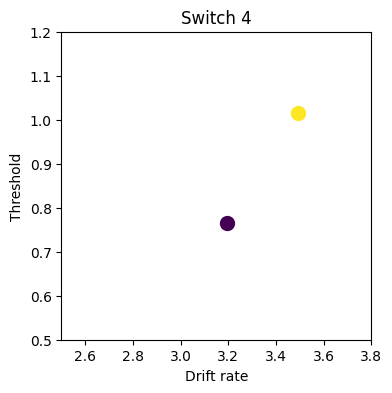

In [10]:
# Calculate the means
means = results.groupby(['condition']).mean()

# Define colors for conditions
cmap = cm.get_cmap('viridis', len(means.index.get_level_values('condition').unique()))

# Create the plot
fig, ax = plt.subplots(figsize=(4, 4))

for (condition), data in means.iterrows():
    v = data['v']
    a = data['a']
    color = cmap(condition)
    ax.scatter(v, a, color=color, s=100)

ax.set_xlabel('Drift rate')
ax.set_ylabel('Threshold')
ax.set_xlim([2.5,3.8])  # Set the x-axis limits
ax.set_ylim([0.5,1.2])  # Set the y-axis limits
ax.set_title('Switch 4')

plt.show()

# Save means into a csv file on a specified path
means.to_csv('../../Analyses/Experiment4/model_simulations/Experiment4_4_g_fixed_5.csv')

#### Dynamics plot

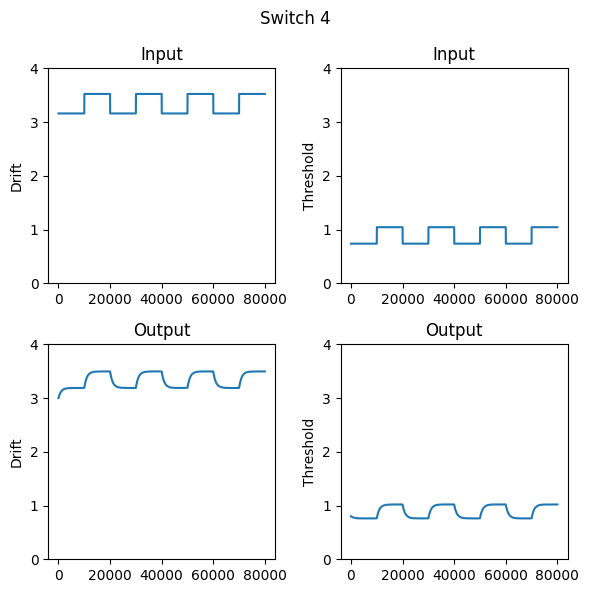

In [57]:
# Subset the data
dynamics = results_dynamics

# Take only the first 16 SOAs
dynamics = dynamics.iloc[0:32*soa,:]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
fig.suptitle('Switch 4')

# Define colors for conditions
color_map = {'1': 'red', '2': 'blue'}  # Update with actual condition names

# Drift rate
axs[0,0].plot(dynamics['v_star'])
axs[0,0].set_title('Input')
axs[0,0].set_ylim(0,4)
axs[0,0].set_ylabel('Drift')

axs[1, 0].plot(dynamics['v_traject'])
axs[1,0].set_title('Output')
axs[1,0].set_ylim(0,4)
axs[1,0].set_ylabel('Drift')

# Threshold
axs[0,1].plot(dynamics['a_star'])
axs[0,1].set_title('Input')
axs[0,1].set_ylim(0,4)
axs[0,1].set_ylabel('Threshold')

axs[1,1].plot(dynamics['a_traject'])
axs[1,1].set_title('Output')
axs[1,1].set_ylim(0,4)
axs[1,1].set_ylabel('Threshold')

plt.tight_layout()
plt.show()

### Switch every 2

#### Simulate

In [13]:
# Parameters 
t = 0.3831758
soa = 2750 
nintervals = 512

#------------------------------------------------------------------------------
# SWITCH 2 BLOCK
#------------------------------------------------------------------------------
switch = 2
w1_0 = 17.7866  # Correct resp sensitivity for condition 0
w1_1 = 20.5033  # Correct resp sensitivity for condition 1
w2_0 = 136.0729 # Incorrect resp sensitivity for condition 0
w2_1 = 1787.4 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([0,1])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_varying = results
results_varying["block_type"] = np.repeat('varying',results_varying.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['condition'] = inputs['conditions']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_varying_dynamics = results_dynamics
results_varying_dynamics["block_type"] = np.repeat('varying',results_varying_dynamics.shape[0]) ## Add the block information

# Merge the results
results = results_varying
results_dynamics = results_varying_dynamics



#### 2D plot

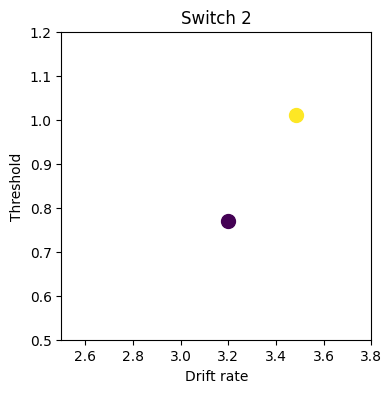

In [14]:
# Calculate the means 
means = results.groupby(['condition']).mean()

# Define colors for conditions
cmap = cm.get_cmap('viridis', len(means.index.get_level_values('condition').unique()))

# Create the plot
fig, ax = plt.subplots(figsize=(4, 4))

for (condition), data in means.iterrows():
    v = data['v']
    a = data['a']
    color = cmap(condition)
    ax.scatter(v, a, color=color, s=100)

ax.set_xlabel('Drift rate')
ax.set_ylabel('Threshold')
ax.set_xlim([2.5,3.8])  # Set the x-axis limits
ax.set_ylim([0.5,1.2])  # Set the y-axis limits
ax.set_title('Switch 2')

plt.show()

# Save means into a csv file on a specified path
means.to_csv('../../Analyses/Experiment4/model_simulations/Experiment4_2_g_fixed_5.csv')


#### Dynamics plot

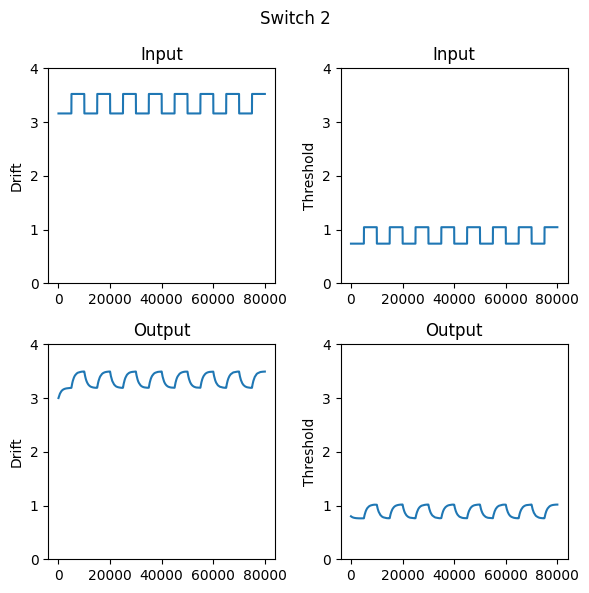

In [60]:
# Subset the data
dynamics = results_dynamics

# Take only the first 16 SOAs
dynamics = dynamics.iloc[0:32*soa,:]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
fig.suptitle('Switch 2')

# Define colors for conditions
color_map = {'1': 'red', '2': 'blue'}  # Update with actual condition names

# Drift rate
axs[0,0].plot(dynamics['v_star'])
axs[0,0].set_title('Input')
axs[0,0].set_ylim(0,4)
axs[0,0].set_ylabel('Drift')

axs[1, 0].plot(dynamics['v_traject'])
axs[1,0].set_title('Output')
axs[1,0].set_ylim(0,4)
axs[1,0].set_ylabel('Drift')

# Threshold
axs[0,1].plot(dynamics['a_star'])
axs[0,1].set_title('Input')
axs[0,1].set_ylim(0,4)
axs[0,1].set_ylabel('Threshold')

axs[1,1].plot(dynamics['a_traject'])
axs[1,1].set_title('Output')
axs[1,1].set_ylim(0,4)
axs[1,1].set_ylabel('Threshold')

plt.tight_layout()
plt.show()

## Study 4 with different gains

### Fixed

#### Simulate

In [9]:
# Gain
g = 5

# Parameters 
t = 0.3831758
soa = 2750 
nintervals = 256
switch = 4

#------------------------------------------------------------------------------
# FIXED BLOCK (CONDITION 0)
#------------------------------------------------------------------------------
w1_0 = 17.7866  # Correct resp sensitivity for condition 0
w1_1 = 17.7866  # Correct resp sensitivity for condition 1
w2_0 = 136.0729 # Incorrect resp sensitivity for condition 0
w2_1 = 136.0729 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([0,0])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_fixed_cond0 = results
results_fixed_cond0["block_type"] = np.repeat('fixed',results_fixed_cond0.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['condition'] = inputs['conditions']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_fixed_cond0_dynamics = results_dynamics
results_fixed_cond0_dynamics["block_type"] = np.repeat('fixed',results_fixed_cond0_dynamics.shape[0]) ## Add the block information

#------------------------------------------------------------------------------
# FIXED BLOCK (CONDITION 1)
#------------------------------------------------------------------------------
w1_0 = 20.5033 # Correct resp sensitivity for condition 0
w1_1 = 20.5033  # Correct resp sensitivity for condition 1
w2_0 = 1787.4 # Incorrect resp sensitivity for condition 0
w2_1 = 1787.4 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([1,1])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_fixed_cond1 = results
results_fixed_cond1["block_type"] = np.repeat('fixed',results_fixed_cond1.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['condition'] = inputs['conditions']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_fixed_cond1_dynamics = results_dynamics
results_fixed_cond1_dynamics["block_type"] = np.repeat('fixed',results_fixed_cond1_dynamics.shape[0]) ## Add the block information

# Merge the results
results = pd.concat([results_fixed_cond0,results_fixed_cond1], axis=0)
results_dynamics = pd.concat([results_fixed_cond0_dynamics,results_fixed_cond1_dynamics], axis=0)


#### 2D plot

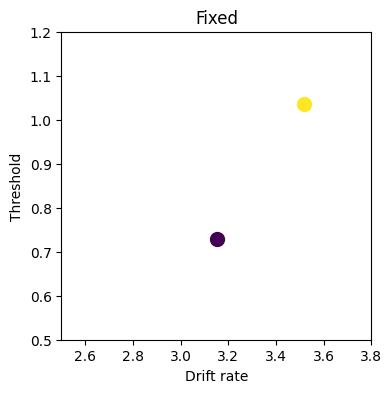

In [16]:
# Calculate the means 
means = results.groupby(['condition']).mean()

# Define colors for conditions
cmap = cm.get_cmap('viridis', len(means.index.get_level_values('condition').unique()))

# Create the plot
fig, ax = plt.subplots(figsize=(4, 4))

for (condition), data in means.iterrows():
    v = data['v']
    a = data['a']
    color = cmap(condition)
    ax.scatter(v, a, color=color, s=100)

ax.set_xlabel('Drift rate')
ax.set_ylabel('Threshold')
ax.set_xlim([2.5,3.8])  # Set the x-axis limits
ax.set_ylim([0.5,1.2])  # Set the y-axis limits
ax.set_title('Fixed')

plt.show()

# Save means into a csv file on a specified path
means.to_csv('../../Analyses/Experiment4/model_simulations/Experiment4_fixed_g_varying_5.csv')

#### Dynamics plot

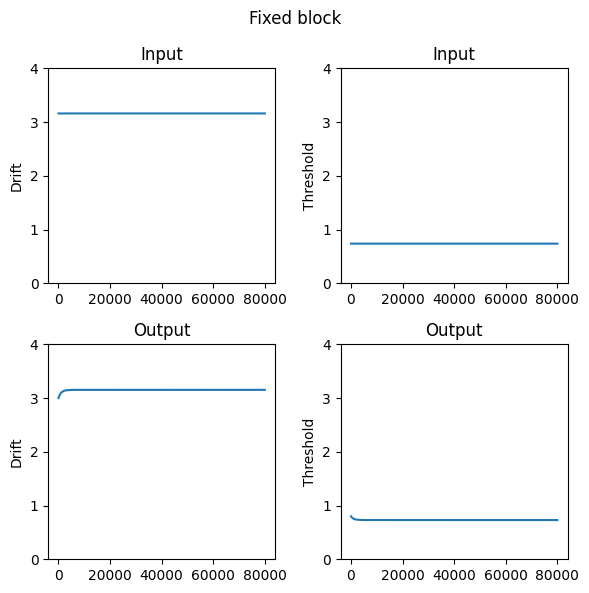

In [ ]:
# Subset the data
dynamics = results_dynamics

# Take only the first 16 SOAs
dynamics = dynamics.iloc[0:32*soa,:]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
fig.suptitle('Fixed block')

# Define colors for conditions
color_map = {'1': 'red', '2': 'blue'}  # Update with actual condition names

# Drift rate
axs[0,0].plot(dynamics['v_star'])
axs[0,0].set_title('Input')
axs[0,0].set_ylim(0,4)
axs[0,0].set_ylabel('Drift')

axs[1, 0].plot(dynamics['v_traject'])
axs[1,0].set_title('Output')
axs[1,0].set_ylim(0,4)
axs[1,0].set_ylabel('Drift')

# Threshold
axs[0,1].plot(dynamics['a_star'])
axs[0,1].set_title('Input')
axs[0,1].set_ylim(0,4)
axs[0,1].set_ylabel('Threshold')

axs[1,1].plot(dynamics['a_traject'])
axs[1,1].set_title('Output')
axs[1,1].set_ylim(0,4)
axs[1,1].set_ylabel('Threshold')

plt.tight_layout()
plt.show()

### Switch every 8

#### Simulate

In [13]:
# Gain
g = 3

# Parameters 
t = 0.3831758
soa = 2750 
nintervals = 512

#------------------------------------------------------------------------------
# SWITCH 8 BLOCK
#------------------------------------------------------------------------------
switch = 8
w1_0 = 17.7866  # Correct resp sensitivity for condition 0
w1_1 = 20.5033  # Correct resp sensitivity for condition 1
w2_0 = 136.0729 # Incorrect resp sensitivity for condition 0
w2_1 = 1787.4 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([0,1])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_varying = results
results_varying["block_type"] = np.repeat('varying',results_varying.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['condition'] = inputs['conditions']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_varying_dynamics = results_dynamics
results_varying_dynamics["block_type"] = np.repeat('varying',results_varying_dynamics.shape[0]) ## Add the block information

# Merge the results
results = results_varying
results_dynamics = results_varying_dynamics


#### 2D plot

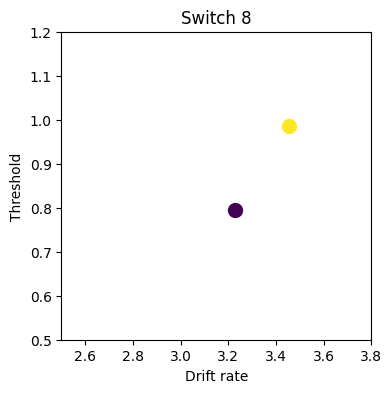

In [18]:
# Calculate the means 
means = results.groupby(['condition']).mean()

# Define colors for conditions
cmap = cm.get_cmap('viridis', len(means.index.get_level_values('condition').unique()))

# Create the plot
fig, ax = plt.subplots(figsize=(4, 4))

for (condition), data in means.iterrows():
    v = data['v']
    a = data['a']
    color = cmap(condition)
    ax.scatter(v, a, color=color, s=100)

ax.set_xlabel('Drift rate')
ax.set_ylabel('Threshold')
ax.set_xlim([2.5,3.8])  # Set the x-axis limits
ax.set_ylim([0.5,1.2])  # Set the y-axis limits
ax.set_title('Switch 8')

plt.show()

# Save means into a csv file on a specified path
means.to_csv('../../Analyses/Experiment4/model_simulations/Experiment4_8_g_varying_3.csv')

#### Dynamics plot

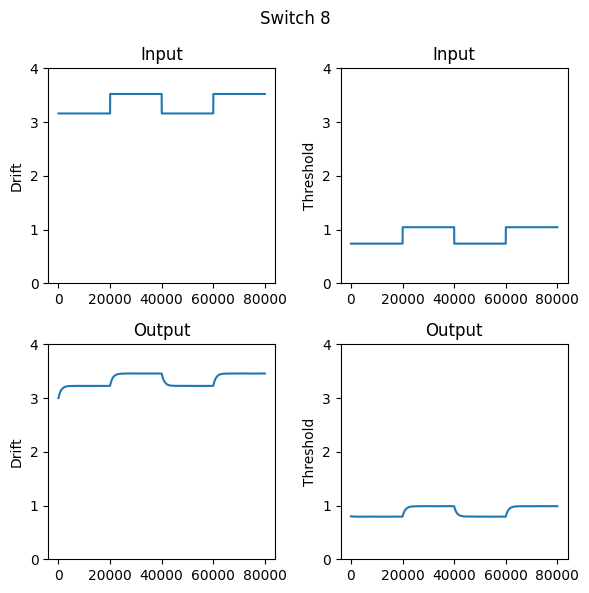

In [73]:
# Subset the data
dynamics = results_dynamics

# Take only the first 16 SOAs
dynamics = dynamics.iloc[0:32*soa,:]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
fig.suptitle('Switch 8')

# Define colors for conditions
color_map = {'1': 'red', '2': 'blue'}  # Update with actual condition names

# Drift rate
axs[0,0].plot(dynamics['v_star'])
axs[0,0].set_title('Input')
axs[0,0].set_ylim(0,4)
axs[0,0].set_ylabel('Drift')

axs[1, 0].plot(dynamics['v_traject'])
axs[1,0].set_title('Output')
axs[1,0].set_ylim(0,4)
axs[1,0].set_ylabel('Drift')

# Threshold
axs[0,1].plot(dynamics['a_star'])
axs[0,1].set_title('Input')
axs[0,1].set_ylim(0,4)
axs[0,1].set_ylabel('Threshold')

axs[1,1].plot(dynamics['a_traject'])
axs[1,1].set_title('Output')
axs[1,1].set_ylim(0,4)
axs[1,1].set_ylabel('Threshold')

plt.tight_layout()
plt.show()

### Switch every 4

#### Simulate

In [5]:
# Gain
g = 2.5

# Parameters 
t = 0.3831758
soa = 2750 
nintervals = 512

#------------------------------------------------------------------------------
# SWITCH 4 BLOCK
#------------------------------------------------------------------------------
switch = 4
w1_0 = 17.7866  # Correct resp sensitivity for condition 0
w1_1 = 20.5033  # Correct resp sensitivity for condition 1
w2_0 = 136.0729 # Incorrect resp sensitivity for condition 0
w2_1 = 1787.4 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([0,1])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_varying = results
results_varying["block_type"] = np.repeat('varying',results_varying.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['condition'] = inputs['conditions']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_varying_dynamics = results_dynamics
results_varying_dynamics["block_type"] = np.repeat('varying',results_varying_dynamics.shape[0]) ## Add the block information

# Merge the results
results = results_varying
results_dynamics = results_varying_dynamics


#### 2D plot

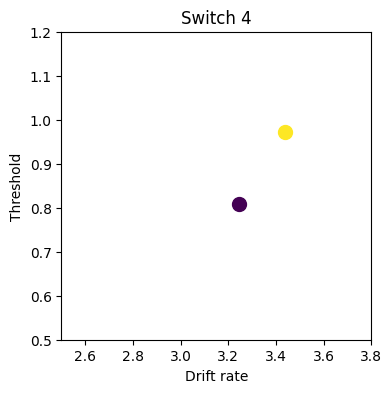

In [20]:
# Calculate the means
means = results.groupby(['condition']).mean()

# Define colors for conditions
cmap = cm.get_cmap('viridis', len(means.index.get_level_values('condition').unique()))

# Create the plot
fig, ax = plt.subplots(figsize=(4, 4))

for (condition), data in means.iterrows():
    v = data['v']
    a = data['a']
    color = cmap(condition)
    ax.scatter(v, a, color=color, s=100)

ax.set_xlabel('Drift rate')
ax.set_ylabel('Threshold')
ax.set_xlim([2.5,3.8])  # Set the x-axis limits
ax.set_ylim([0.5,1.2])  # Set the y-axis limits
ax.set_title('Switch 4')

plt.show()

# Save means into a csv file on a specified path
means.to_csv('../../Analyses/Experiment4/model_simulations/Experiment4_4_g_varying_2.5.csv')

#### Dynamics plot

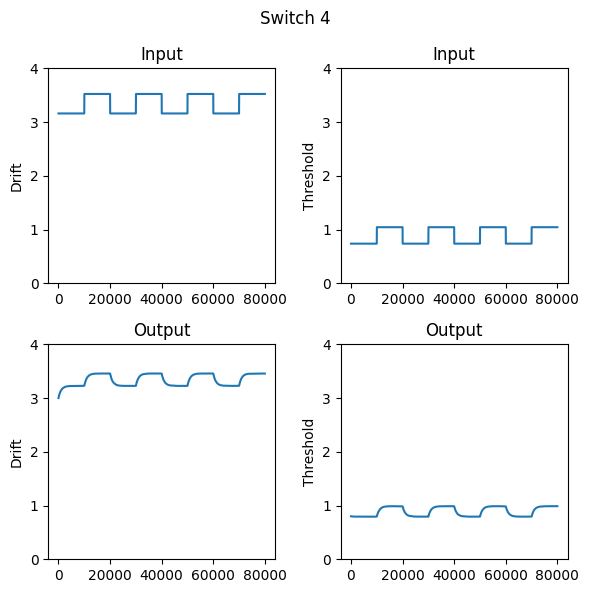

In [68]:
# Subset the data
dynamics = results_dynamics

# Take only the first 16 SOAs
dynamics = dynamics.iloc[0:32*soa,:]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
fig.suptitle('Switch 4')

# Define colors for conditions
color_map = {'1': 'red', '2': 'blue'}  # Update with actual condition names

# Drift rate
axs[0,0].plot(dynamics['v_star'])
axs[0,0].set_title('Input')
axs[0,0].set_ylim(0,4)
axs[0,0].set_ylabel('Drift')

axs[1, 0].plot(dynamics['v_traject'])
axs[1,0].set_title('Output')
axs[1,0].set_ylim(0,4)
axs[1,0].set_ylabel('Drift')

# Threshold
axs[0,1].plot(dynamics['a_star'])
axs[0,1].set_title('Input')
axs[0,1].set_ylim(0,4)
axs[0,1].set_ylabel('Threshold')

axs[1,1].plot(dynamics['a_traject'])
axs[1,1].set_title('Output')
axs[1,1].set_ylim(0,4)
axs[1,1].set_ylabel('Threshold')

plt.tight_layout()
plt.show()

### Switch every 2

#### Simulate

In [7]:
# Gain
g = 2

# Parameters 
t = 0.3831758
soa = 2750 
nintervals = 512

#------------------------------------------------------------------------------
# SWITCH 2 BLOCK
#------------------------------------------------------------------------------
switch = 2
w1_0 = 17.7866  # Correct resp sensitivity for condition 0
w1_1 = 20.5033  # Correct resp sensitivity for condition 1
w2_0 = 136.0729 # Incorrect resp sensitivity for condition 0
w2_1 = 1787.4 # Incorrect resp sensitivity for condition 1
#------------------------------------------------------------------------------
# Find optimal control states
#------------------------------------------------------------------------------
v_star0, a_star0 = optimal_control(w1_0,w2_0,t,initial_guess,bounds)
v_star1, a_star1 = optimal_control(w1_1,w2_1,t,initial_guess,bounds)

#------------------------------------------------------------------------------
# Create inputs for control movement
#------------------------------------------------------------------------------
goals = {'v':np.array([v_star0,v_star1]),
         'a':np.array([a_star0,a_star1]),
         'conditions':np.array([0,1])}

inputs = input(goals, soa, switch, nintervals)

#------------------------------------------------------------------------------
# Simulate
#------------------------------------------------------------------------------
a_traject, v_traject = ctrl_movement(a0,v0,goals,inputs,tau,eta,dt,g,theta)

# Save the results in a dataframe
results = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals)) # initialize the results matrix
results['v'] = v_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['a'] = a_traject[soa-1::soa] # Take only the v & a values at the end of each soa
results['v_star'] = inputs['v'][soa-1::soa]
results['a_star'] = inputs['a'][soa-1::soa]
results['condition'] = inputs['conditions'][soa-1::soa]

results_varying = results
results_varying["block_type"] = np.repeat('varying',results_varying.shape[0]) ## Add the block information

# Save the dynamics results in a dataframe
results_dynamics = pd.DataFrame(columns=['condition','v','a','v_star','a_star'],index=range(nintervals*soa)) # initialize the results matrix
results_dynamics['v_star'] = inputs['v']
results_dynamics['a_star'] = inputs['a']
results_dynamics['condition'] = inputs['conditions']
results_dynamics['v_traject'] = v_traject 
results_dynamics['a_traject'] = a_traject

results_varying_dynamics = results_dynamics
results_varying_dynamics["block_type"] = np.repeat('varying',results_varying_dynamics.shape[0]) ## Add the block information

# Merge the results
results = results_varying
results_dynamics = results_varying_dynamics


#### 2D plot

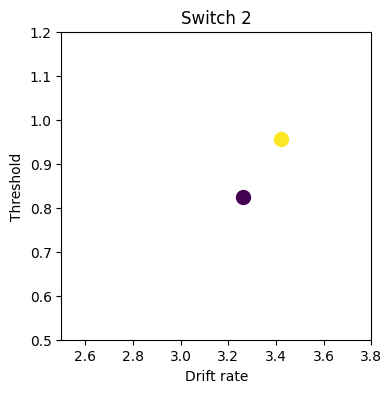

In [22]:
# Calculate the means 
means = results.groupby(['condition']).mean()

# Define colors for conditions
cmap = cm.get_cmap('viridis', len(means.index.get_level_values('condition').unique()))

# Create the plot
fig, ax = plt.subplots(figsize=(4, 4))

for (condition), data in means.iterrows():
    v = data['v']
    a = data['a']
    color = cmap(condition)
    ax.scatter(v, a, color=color, s=100)

ax.set_xlabel('Drift rate')
ax.set_ylabel('Threshold')
ax.set_xlim([2.5,3.8])  # Set the x-axis limits
ax.set_ylim([0.5,1.2])  # Set the y-axis limits
ax.set_title('Switch 2')

plt.show()

# Save means into a csv file on a specified path
means.to_csv('../../Analyses/Experiment4/model_simulations/Experiment4_2_g_varying_2.csv')


#### Dynamics plot

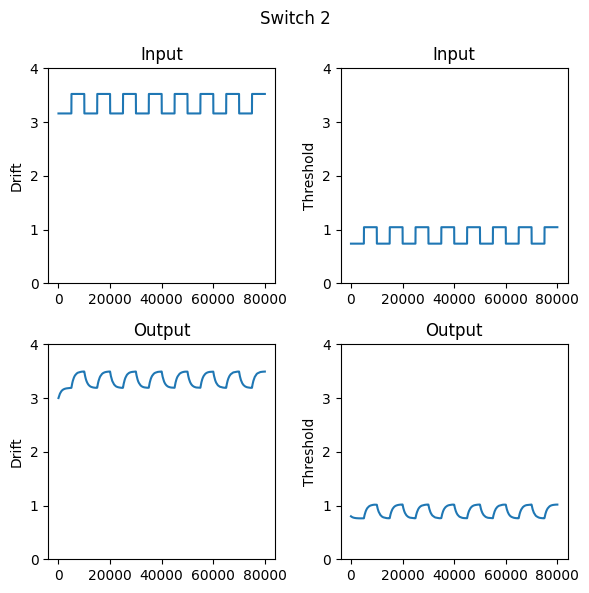

In [ ]:
# Subset the data
dynamics = results_dynamics

# Take only the first 16 SOAs
dynamics = dynamics.iloc[0:32*soa,:]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
fig.suptitle('Switch 2')

# Define colors for conditions
color_map = {'1': 'red', '2': 'blue'}  # Update with actual condition names

# Drift rate
axs[0,0].plot(dynamics['v_star'])
axs[0,0].set_title('Input')
axs[0,0].set_ylim(0,4)
axs[0,0].set_ylabel('Drift')

axs[1, 0].plot(dynamics['v_traject'])
axs[1,0].set_title('Output')
axs[1,0].set_ylim(0,4)
axs[1,0].set_ylabel('Drift')

# Threshold
axs[0,1].plot(dynamics['a_star'])
axs[0,1].set_title('Input')
axs[0,1].set_ylim(0,4)
axs[0,1].set_ylabel('Threshold')

axs[1,1].plot(dynamics['a_traject'])
axs[1,1].set_title('Output')
axs[1,1].set_ylim(0,4)
axs[1,1].set_ylabel('Threshold')

plt.tight_layout()
plt.show()